In [1]:
%matplotlib inline
%load_ext Cython
import matplotlib.pylab as plt
import time

In [2]:
num_steps = 100
scale = 50
damping= 0.25
initial_P = 250
stop_step = 100

In [17]:
%%cython -a
from numpy.core.umath import pi
from numpy.ma import sin
import time
cimport cython

def wave_propogation(num_steps,scale,damping,initial_P,stop_step):
    omega = 3 / (2 * pi)
    
    size_x = 2 * scale + 1
    size_y = 2 * scale + 1 

    # V velocity
    # P presure
    # Initialization
    P = [[0.0 for x in range(size_x)] for y in range(size_y)]
    V = [[[0.0, 0.0, 0.0, 0.0] for x in range(size_x)] for y in range(size_y)]
    P[scale][scale] = initial_P
    for step in range(num_steps):
        if(step <= stop_step):
            P[scale][scale] = initial_P * sin(omega * step)
        for i in range(size_y):
            for j in range(size_x):
                V[i][j][0] = V[i][j][0] + P[i][j] - P[i - 1][j] if i > 0 else P[i][j]
                V[i][j][1] = V[i][j][1] + P[i][j] - P[i][j + 1] if j < size_x - 1 else P[i][j]
                V[i][j][2] = V[i][j][2] + P[i][j] - P[i + 1][j] if i < size_y - 1 else P[i][j]
                V[i][j][3] = V[i][j][3] + P[i][j] - P[i][j - 1] if j > 0 else P[i][j]
                
        for i in range(size_y):
            for j in range(size_x):
                P[i][j] -= 0.5 * damping * sum(V[i][j])
    return P

2.06 Sec, 48.51 Hz


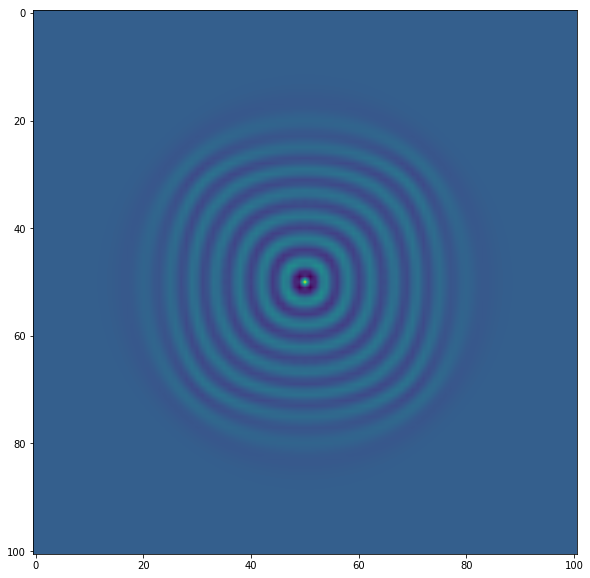

In [18]:
plt.figure(figsize=(10,10))
start = time.time()
pressure = wave_propogation(num_steps,scale,damping,initial_P,stop_step)
stop = time.time()
print(f"{stop - start:.2f} Sec, {num_steps / (stop - start):.2f} Hz")
plt.imshow(pressure,cmap='viridis_r',interpolation='bilinear')

#### Lets use the heatmap to speed up the code even more


Based on previous heatmap:

1. Making loops faster
    - Give types to loop varialbes (i,j,step)
    - This will make the loops more C like
2. Make all varialbes C varialbes
    - Give all the variables types
3. Make accessing the P and V faster
    - Change them to C arrays
    - Turn off python style accessing of P and V
4. Use C function whenever possible
    - Replace sin and sum


In [21]:
%%cython -a
from numpy.core.umath import pi
from numpy.ma import sin
import time
cimport cython

def wave_propogation(num_steps,scale,damping,initial_P,stop_step):
    omega = 3 / (2 * pi)
    
    size_x = 2 * scale + 1
    size_y = 2 * scale + 1 

    # V velocity
    # P presure
    # Initialization
    P = [[0.0 for x in range(size_x)] for y in range(size_y)]
    V = [[[0.0, 0.0, 0.0, 0.0] for x in range(size_x)] for y in range(size_y)]
    P[scale][scale] = initial_P
    for step in range(num_steps):
        if(step <= stop_step):
            P[scale][scale] = initial_P * sin(omega * step)
        for i in range(size_y):
            for j in range(size_x):
                V[i][j][0] = V[i][j][0] + P[i][j] - P[i - 1][j] if i > 0 else P[i][j]
                V[i][j][1] = V[i][j][1] + P[i][j] - P[i][j + 1] if j < size_x - 1 else P[i][j]
                V[i][j][2] = V[i][j][2] + P[i][j] - P[i + 1][j] if i < size_y - 1 else P[i][j]
                V[i][j][3] = V[i][j][3] + P[i][j] - P[i][j - 1] if j > 0 else P[i][j]
                
        for i in range(size_y):
            for j in range(size_x):
                P[i][j] -= 0.5 * damping * sum(V[i][j])
    return P

# Final Results
- ....
- ....
- ....
- ....
- ....
- ....
- ....
- ....
- ....
- ....
- ....

In [22]:
%%cython -a
import time
# Using libc.math pi and sin functions
from libc.math cimport M_PI as pi
from libc.math cimport sin as sin
cimport cython

# Using cvarray to make C style array
from cython.view cimport array as cvarray

# These turn off some python features for accessing arrays as python arrays
@cython.boundscheck(False)
@cython.wraparound(False)
# This turns off checks for divide by 0 and will seg fault instead of throw a warning
@cython.cdivision(True)
# Gave all the input variables types
def wave_propogation_fast(int num_steps, int scale,float damping,float initial_P,int stop_step):
    # Give types to variables we use to calculate with
    cdef float omega =  3.0 / (2.0 * pi)
    cdef int size_x = 2 * scale + 1
    cdef int size_y = 2 * scale + 1 
    
    # Give types to loop iterator variables to make loops C loops
    cdef int i = 0
    cdef int j = 0
    cdef int step = 0

    # Setup 
    cdef float [:,:] P = cvarray(shape=(size_x, size_y), itemsize=sizeof(float), format="f")
    P[:,:] = 0.0
    cdef float [:,:,:] V = cvarray(shape=(size_x, size_y,4), itemsize=sizeof(float), format="f")
    V[:,:,:] = 0.0
    
    P[scale][scale] = initial_P
    
    for step in range(num_steps):
        if(step <= stop_step):
            P[scale][scale] = initial_P * sin(omega * step)
        for i in range(size_y):
            for j in range(size_x):
                V[i][j][0] = V[i][j][0] + P[i][j] - P[i - 1][j] if i > 0 else P[i][j]
                V[i][j][1] = V[i][j][1] + P[i][j] - P[i][j + 1] if j < size_x - 1 else P[i][j]
                V[i][j][2] = V[i][j][2] + P[i][j] - P[i + 1][j] if i < size_y - 1 else P[i][j]
                V[i][j][3] = V[i][j][3] + P[i][j] - P[i][j - 1] if j > 0 else P[i][j]
                
        for i in range(size_y):
            for j in range(size_x):
                P[i][j] -= 0.5 * damping * (V[i][j][0]+V[i][j][1]+V[i][j][2]+V[i][j][3])
    return P

0.01 Sec, 14513.66 Hz


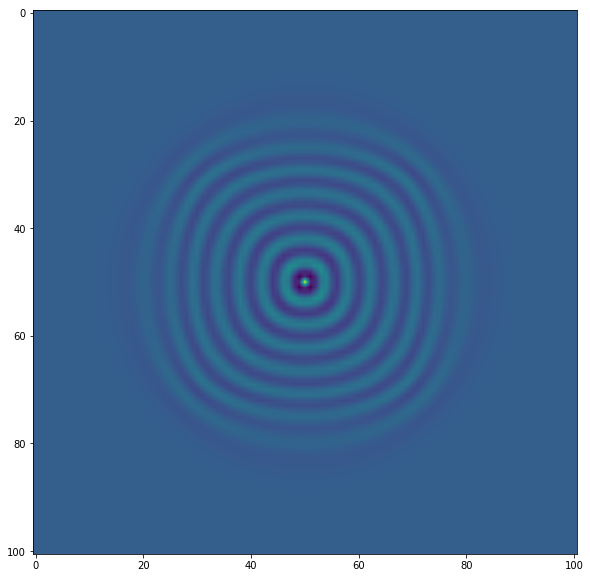

In [23]:
plt.figure(figsize=(10,10))
start = time.time()
pressure = wave_propogation_fast(num_steps,scale,damping,initial_P,stop_step)
stop = time.time()
print(f"{stop - start:.2f} Sec, {num_steps / (stop - start):.2f} Hz")
plt.imshow(pressure,cmap='viridis_r',interpolation='bilinear')